In [10]:
import os
import librosa
# import pydub
from pydub import AudioSegment
import numpy as np
import copy
import random
from scipy import signal as scipy_signal
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim

import datetime

from torch.utils.tensorboard import SummaryWriter

import threading
import time

from tqdm.notebook import tqdm

import glob

In [81]:
answer_list = [' ', '_hey_liku', 'bed', 'bird', 'cat', 'dog', 'down', 'eight', 'five', 'four', 'go', 'happy', 'house', 'left', 'marvin', 'nine', 'no', 'off', 'on', 'one', 'right', 'seven', 'sheila', 'six', 'stop', 'three', 'tree', 'two', 'up', 'wow', 'yes', 'zero']

In [7]:
class basic_rnn_model(nn.Module):
#     def __init__(self, first_kernel_size, second_kernel_size, dropout_rate, num_labels):
    def __init__(self):
        super(basic_rnn_model, self).__init__()
        
        self.gru_1 = nn.GRU(321, 512, 1, bidirectional=False)
        self.gru_2 = nn.GRU(512, 512, 1, bidirectional=False)
        self.gru_3 = nn.GRU(512, 512, 1, bidirectional=False)
        self.gru_4 = nn.GRU(512, 512, 1, bidirectional=False)

        self.flatten = nn.Flatten()
        self.fc = nn.Linear(512, 32)
        
    def forward(self, input_tensor):
        
        # (B, F, T)
        input_tensor.transpose_(0, 2) # (T, F, B)
        input_tensor.transpose_(1, 2) # (T, B, F)
        tensor, _ = self.gru_1(input_tensor)
        
        tensor = F.relu(tensor)
        tensor = F.dropout(tensor, 0.1, training=True)
        tensor, _ = self.gru_2(tensor)

        tensor = F.relu(tensor)
        tensor = F.dropout(tensor, 0.1, training=True)
        tensor, _ = self.gru_3(tensor)
        
        tensor = F.relu(tensor)
        tensor = F.dropout(tensor, 0.1, training=True)
        tensor, hidden = self.gru_4(tensor) # Hidden (2[Direction], B, H)

        tensor = F.relu(hidden)
        tensor = F.dropout(tensor, 0.1, training=True)
        
        tensor.transpose_(0, 1) # (B, T, F)
        tensor = self.flatten(tensor)
        tensor = self.fc(tensor)
        pred_tensor = F.log_softmax(tensor, dim=-1)
        
        return pred_tensor


In [8]:
model = basic_rnn_model()

In [93]:
print(glob.glob('models/*'))

['models/hey_liku_4_layer_rnn_hidden_fc_uni_dir_512_2020-02-10_11-48-11.pt', 'models/hey_liku_4_layer_rnn_hidden_fc_uni_dir_512_2020-02-10_15-41-05.pt']


In [94]:
model_path = glob.glob('models/*')[1]

In [95]:
model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu'))) # Testing on CPU Machine

<All keys matched successfully>

In [109]:
import sounddevice as sd
import IPython.display as ipd
import matplotlib.pyplot as plt

fs = 16000  # Sample rate
sr = fs
seconds = 1.2  # Duration of recording

nsc_in_ms = 40
nov_in_ms = 0
nsc_in_sample = int(nsc_in_ms / 1000 * sr)
nov_in_sample = int(nov_in_ms / 1000 * sr)

In [110]:
myrecording = sd.rec(int(seconds * fs), samplerate=fs, channels=2)
sd.wait()  # Wait until recording is finished

In [111]:
# plt.figure()
# plt.plot(myrecording)
# plt.show()

f, t, Zxx = scipy_signal.stft(myrecording[:, 0], fs=sr, 
                              nperseg=nsc_in_sample,
                              noverlap=nov_in_sample)

Sxx = np.abs(Zxx)

normalized_spectrogram = (20 * np.log10(np.maximum(Sxx, 1e-8)) + 160) / 160

# print('[Normalized Spectrogram Shape: {}]'.format(normalized_spectrogram.shape))

# plt.figure()
# plt.imshow(normalized_spectrogram, origin='reversed')
# plt.show()

single_batch = torch.tensor(np.expand_dims(normalized_spectrogram, 0))

print('[Batch Shape: {}]'.format(single_batch.shape))

ipd.Audio(myrecording[:, 0], rate=fs)

[Batch Shape: torch.Size([1, 321, 31])]


In [112]:
model.eval()
pred_tensor = model(single_batch)

pred_array = pred_tensor.detach().numpy().T

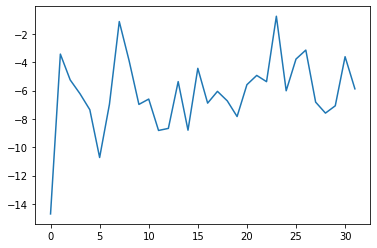

six


In [113]:
plt.figure()
plt.plot(pred_array)
plt.show()

idx = np.argmax(pred_array)
print(answer_list[idx])